In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Training a ML model in anomalous diffusion data 

### Creating a training datasets
We make use of the `andi-datasets` python library to generate a dataset with which we will train the machine. Following the results of our paper, here we showcase the training of a machine with ATTM and FBM trajectories, with exponent $\alpha \in [0.1,1]$. For details on the generation of the dataset, please visit the [andi-datasets repo](https://github.com/AnDiChallenge/andi_datasets/).

In [4]:
from andi_datasets.datasets_theory import datasets_theory as DT
from andi_datasets.utils_trajectories import normalize

N = 1000                          # number of trajectories per model and exponent
T = 30                            # length of the trajectories
models = [0,2]                    # label of the diffusion models considered (ATTM = 0, FBM = 2)
exponents = np.arange(0.1,1,0.05) # anomalous exponents considered
path = 'datasets/'                # path where to save the dataset (once saved, you can load the
                                  # dataset, see details in andi-datasets repo)

# Create the dataset
dataset = DT().create_dataset(T = T,
                              N_models= N, 
                              exponents = exponents, 
                              models = models, 
                              save_trajectories = True, 
                              path = path)

100%|████████████████████████████████████████| 1000/1000 [00:00<00:00, 5863.60it/s, exponent=0.95, model=fbm, saving=1]


Now we separate the datasets in a training/test set dataset with ratio 80-20:

In [5]:
# First, we shuffle the dataset to mix all exponents and models
np.random.shuffle(dataset)

# Now we separate the trajectories (e.g. the T-2 last elements of each row from dataset, see 
# andi-datasets for more details)
# Importantly, we also normalize the trajectories
ratio = int(0.8*dataset.shape[0])
X_a = normalize(dataset[:ratio, 2:]).reshape(ratio, T, 1)
X_e = normalize(dataset[ratio:, 2:]).reshape(N-ratio, T, 1)

# This is the final size of the training dataset
X_e.shape

(7200, 30, 1)

We do the same with the labels. Here we will focus on the diffusion model (e.g. a classification problem). Let's create the labels for both training and test datasets.

In [6]:
from keras.utils import to_categorical

# We first change the label of FBM trajectories from 2 -> 1
dataset[dataset[:,0] == 2, 0] = 1
# And then we split the labels as we did with the trajectories
Y_a = to_categorical(dataset[:ratio, 0])
Y_e = to_categorical(dataset[ratio:, 0])

# Moreover, let's save the exponents of this trajectories to do some further analysis later.
expo_e = dataset[ratio:,1]

## Defining the neural networks
Our next step is to define the neural network we will train to predict diffusion models. We will use the architecture presented in our paper, inspired by the LSTM fully convolution network presented in [this paper](https://doi.org/10.1109/ACCESS.2017.2779939). In our case, we change the LSTM layers by a GRU layer. The architecture has the following shape:

<center>
<img src="figures/ml_architecture.png" alt="drawing" width="250"/>
<center>
    
The following cells define the model. If you want to load 

In [7]:
# Models
from keras.models import Sequential, Model, load_model
# main layers
from keras.layers import Dense, Conv1D, Flatten, GRU
# other NN utils
from keras.layers import Dropout, Concatenate, Input, BatchNormalization
# Optimizer
from keras.optimizers import Adam

In [8]:
# GRU arm (2 GRU layers)
input1 = Input(shape=(T,1))
x1 = GRU(3, return_sequences=True)(input1)
x1 = GRU(3)(x1)


# CNN arm (3 CNN layers + flatten layer)
input2 = Input(shape=(T, 1))
x2 = Conv1D(filters=6, kernel_size=3 ,strides=1,
            kernel_initializer= 'uniform',
            activation= 'relu')(input2)
x2 = Conv1D(filters=6, kernel_size=5 ,strides=1,
            kernel_initializer= 'uniform',
            activation= 'relu')(x2)
x2 = Conv1D(filters=6, kernel_size=2 ,strides=1,
            kernel_initializer= 'uniform',
            activation= 'relu')(x2)
x2 = Flatten()(x2)


# Contact and fully connected layer
contact = Concatenate()([x1, x2])
fc = Dense(128, activation='sigmoid')(contact)
fc = Dropout(0.25)(fc)
fc = Dense(64, activation='sigmoid')(fc)
fc = Dropout(0.25)(fc)
out = Dense(len(models), activation='softmax')(fc)

# Merge everythin into a model
fullyCNN = Model(inputs=[input1, input2], outputs=out)

# Define loss and optimizer
fullyCNN.compile(loss='kullback_leibler_divergence',
                 optimizer=Adam(),
                 metrics=['accuracy'])

# Let's see a summary of the model
fullyCNN.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 28, 6)        24          ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 30, 1)]      0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 24, 6)        186         ['conv1d[0][0]']                 
                                                                                              

## Training the Neural Network
Now that we have defined both the model and the datasets, we can train the machine. If you don't want to train it, skip this cell and load the pre-trained model you will find in the `ML_trained_models` folder.

In [12]:
batch_size = 350
epochs = 20

history = fullyCNN.fit([X_a, X_a], Y_a,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=([X_e, X_e], Y_e))

Epoch 1/20
83/83 [==============================] - 14s 78ms/step - loss: 0.6818 - accuracy: 0.5799 - val_loss: 0.5674 - val_accuracy: 0.7106
Epoch 2/20
83/83 [==============================] - 6s 69ms/step - loss: 0.5728 - accuracy: 0.7066 - val_loss: 0.5543 - val_accuracy: 0.7194
Epoch 3/20
83/83 [==============================] - 5s 59ms/step - loss: 0.5568 - accuracy: 0.7185 - val_loss: 0.5441 - val_accuracy: 0.7247
Epoch 4/20
83/83 [==============================] - 5s 58ms/step - loss: 0.5435 - accuracy: 0.7275 - val_loss: 0.5320 - val_accuracy: 0.7361
Epoch 5/20
83/83 [==============================] - 5s 58ms/step - loss: 0.5319 - accuracy: 0.7378 - val_loss: 0.5236 - val_accuracy: 0.7401
Epoch 6/20
83/83 [==============================] - 5s 58ms/step - loss: 0.5239 - accuracy: 0.7404 - val_loss: 0.5153 - val_accuracy: 0.7492
Epoch 7/20
83/83 [==============================] - 5s 57ms/step - loss: 0.5117 - accuracy: 0.7518 - val_loss: 0.5034 - val_accuracy: 0.7546
Epoch 8/20
8

In case you want to load a pre-trained model:


In [ ]:
path_model = 'ML_trained_models/fullyCNN_models_Tmax=30.h5'
fullyCNN.load(

In case you want to save your recently trained model:

In [26]:
path_model = 'ML_trained_models/fullyCNN_models_Tmax=30.h5'
fullyCNN.save(path_model)

### Benchmark

We can check the performance of the model by calculating the f1-score and the confusion matrix of the model with respect to the test set (as done in the supplementary figure S5 A):

In [20]:
from sklearn.metrics import confusion_matrix, f1_score
true = np.argmax(Y_e, axis = 1)
pred = np.argmax(fullyCNN.predict([X_e, X_e]), axis = 1)

conf = confusion_matrix(true, pred)/(X_e.shape[0]/2)
f1 = f1_score(true, pred)

225/225 [==============================] - 2s 9ms/step


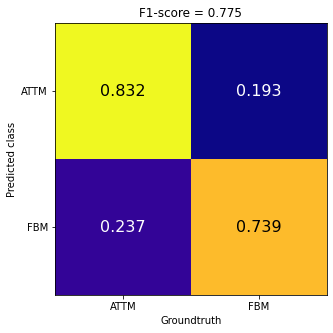

In [24]:
fig, ax= plt.subplots(figsize = (5,5))
ax.matshow(conf, cmap = 'plasma')
for (i, j), z in np.ndenumerate(conf):
    if i == j:
        c = 'k'
    else:
        c = 'w'
            
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center', fontsize = 16, color = c)
plt.setp(ax,
         xticks = [0, 1], xticklabels = ['ATTM', 'FBM'],
         yticks = [0, 1], yticklabels = ['ATTM', 'FBM'],
         xlabel = 'Groundtruth', ylabel = 'Predicted class',
         title = f'F1-score = {round(f1,3)}')
ax.xaxis.set_ticks_position('bottom') 

Similarly, we can check the error made by a model trained to predict the anomalous exponent $\alpha$. In this case, we will directly load a pre-trained model and calculate the prediction error made for trajectories from all models together and separatedly (as done in Supplementary Figure S5 B). First we load the model. In this case we will use a model which has no CNN layers, just the GRU arm (see figure above)

In [28]:
model_exp = load_model('ML_trained_models/GRU_exponents_fbm_alpha=0.05-0.1_Tmax=30.h5')

We now generate separatedly two datasets, one per model (i.e. ATTM and FBM). This way we can see the effect on the prediction as a function of the model. 

In [31]:
N = 1000; T = 30; exponents = np.arange(0.1,1,0.05)

dif = np.zeros((2, N*len(exponents)))

for idx, model in enumerate([2, 0]):
    dataset = DT().create_dataset(T = T, N_models = N, exponents = exponents, models = [model], 
                                  load_trajectories = True, path = path,)
    np.random.shuffle(dataset)
    X_e = normalize(dataset[:, 2:]).reshape(dataset.shape[0], dataset.shape[1]-2, 1)
    Y_e = dataset[:, 1]
    
    expo_p = model_exp.predict(X_e)#[X_e, X_e])
    dif[idx] = (expo_p.flatten()-Y_e)

563/563 [==============================] - 9s 16ms/step


We can see the mean absolute error made for each model. As it is expected, the predictions over ATTM are much worse, as explained in the manuscript and many of its references:

In [34]:
for mod, error in zip(['FBM','ATTM'], np.abs(dif).mean(1)):
    print(mod, f': MAE = {np.round(error,3)}')

FBM : MAE = 0.134
ATTM : MAE = 0.32


We can further investigate this by plotting an histogram of the prediction error:

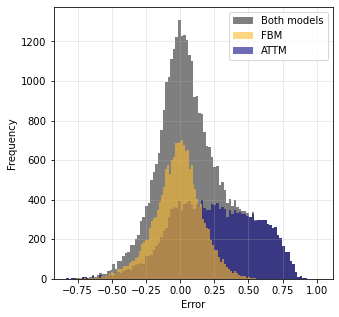

In [35]:
fig, ax = plt.subplots(figsize = (5,5))
plasma = plt.cm.get_cmap('plasma', 21)
newcolors = plasma([0,17])

ax.hist(dif.flatten(), bins = 100, alpha = 0.5, label = 'Both models', color = 'k', zorder = -1);
for d, lab, c, order in zip(dif, ['FBM', 'ATTM'], [newcolors[1], newcolors[0]], [2,1]):
    ax.hist(d, alpha = 0.6, bins = 100, label = lab, color = c, zorder = order)
plt.setp(ax, xlabel = r'Error', ylabel = 'Frequency')
ax.legend()
ax.grid(alpha = 0.3)

# Analyzing experimental data
The section should have convinced you on the suitability of the use of ML for the analysis of anomalous diffusion trajectories. If you are still unconvinced, you can check [this reference](https://doi.org/10.1038/s41467-021-26320-w), where even more powerful ML models have been presented. We will now apply this models to the experimental trajectories presented in our paper. Check the manuscript for details.

We consider here trajectories at 6 different hormone concentrations:

In [41]:
import scipy.io
file = scipy.io.loadmat('experimental_data/Trajectories_PR.mat')
name_experiment = ['Trajectories_EtOH', 'Trajectories_1pM', 'Trajectories_10pM',
                   'Trajectories_100pM', 'Trajectories_1nM', 'Trajectories_10nM']

## Diffusion model 

We will reproduce now Figure 2 B from our paper. For that, we will calculate the diffusion coefficient of each trajectories (by means of the `andi-dataset` library) and then predict the model for each trajectory with the model trained above. 

''

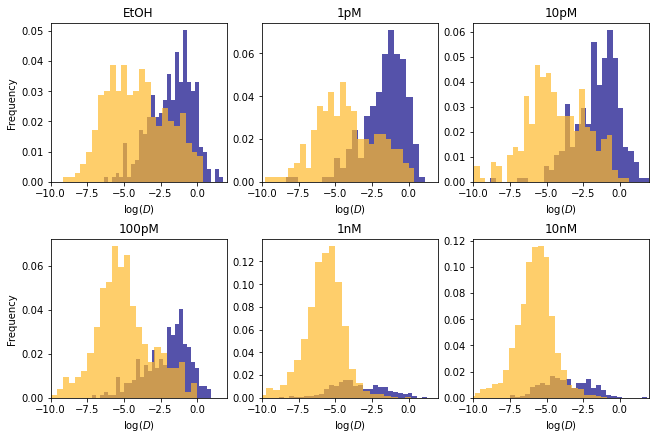

In [61]:
from utils import *
from andi_datasets.analysis import msd_analysis
plasma = plt.cm.get_cmap('plasma', 21)
newcolors = plasma([0,17])

fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize = (9, 6))

perc_attm, perc_fbm = [],[]
for idx,(name, ax) in enumerate(zip(name_experiment, axs.flatten())):  
    
    # Loading and managing trajs
    trajs = file_to_np_cut(file[name], T)
    D = diff_coeff(trajs)
    
    trajs_n = normalize(trajs).reshape(trajs.shape[0], T, 1)
    
    mod = np.argmax(fullyCNN.predict([trajs_n, trajs_n], verbose=0), axis = 1)
    
    ########## Model classsication ##############    
    attm_pop = np.array(D)[mod == 0]
    fbm_pop = np.array(D)[mod == 1]
    # weights
    w_a = np.ones_like(attm_pop)/float(len(trajs_n))
    w_f = np.ones_like(fbm_pop)/float(len(trajs_n))
    
    # % of trajectories   
    perc_attm.append(len(mod[mod == 0])/len(mod))
    perc_fbm.append(len(mod[mod == 1])/len(mod))
    
    ax.hist(np.log(attm_pop), bins = 30, alpha = 0.7, label = 'ATTM', facecolor = newcolors[0], weights = w_a)  
    ax.hist(np.log(fbm_pop), bins = 30, label = r'FBM', facecolor = newcolors[1], alpha = 0.7, weights = w_f) 
    ax.set_title(name[13:])
    
plt.setp(axs, xlabel = r'$\log(D)$', xlim = [-10, 2]);
plt.setp(axs[:, 0], ylabel = 'Frequency')
;

From the previous calculations we can reproduce Figure 2 A, namely, the percentage of particles associated to each diffusion model. Note that, depending on the training of you machine, the result can slightly vary from the one presented in the paper. Nonetheless, qualitatively we always get the same result.

C:\Users\User\AppData\Local\Temp/ipykernel_11548/1922368598.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels);


Text(0.5, 0, 'Hormone concentration (log(M))')

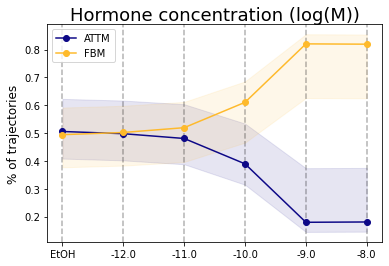

In [63]:
fig, ax = plt.subplots()
conc = np.arange(-13, -7, 1)

for C in conc:
    ax.axvline(C, ls = '--', c = 'k', alpha = 0.3)
ax.plot(conc, perc_attm, '-o', label = 'ATTM', c = newcolors[0])
ax.plot(conc, perc_fbm, '-o', label = 'FBM', c = newcolors[1])


err_attm = np.ones_like(conc)*perc_attm*conf[0,1]
err_fbm = np.ones_like(conc)*perc_fbm*conf[1,0]

ax.fill_between(conc, perc_attm-err_attm, perc_attm+err_fbm, color=newcolors[0], alpha=0.1)
ax.fill_between(conc, perc_fbm-err_fbm, perc_fbm+err_attm, color=newcolors[1], alpha=0.1)

ax.legend()

labels = ax.get_xticks().tolist()
labels[1] = 'EtOH'
ax.set_xticklabels(labels);
ax.set_ylabel('% of trajectories', fontsize = 12)
ax.xaxis.set_label_position('top') 
ax.set_xlabel('Hormone concentration (log(M))', fontsize = 18)

## Anomalous exponent 

Finally, we can now predict the anomalous exponent of the experimental trajectories and use that information to reproduce Figure 2 C from our paper:

[Text(0, 0.5, 'Frequency'), Text(0, 0.5, 'Frequency')]

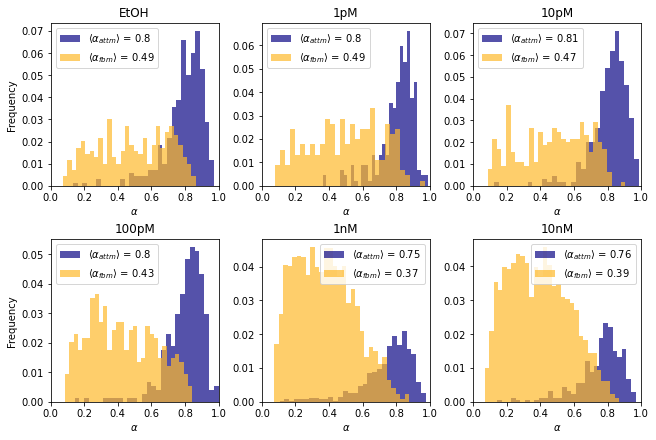

In [73]:
fully_m = False #True
fully_e = False
T_m = 30
T_e = 30

plasma = plt.cm.get_cmap('plasma', 21)
newcolors = plasma([0,17])
# newcmp = ListedColormap(newcolors)

conc = np.array([-13, -12, -11, -10, -9, -8])

fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize = (9, 6))


for idx,(name, ax) in enumerate(zip(name_experiment, axs.flatten())): 
    
    # Loading and managing trajs
    trajs = file_to_np_cut(file[name], T)
    D = diff_coeff(trajs)
    
    trajs = normalize(trajs).reshape(trajs.shape[0], T, 1)
    # Predictions
    exp = model_exp.predict(trajs, verbose = 0)
    mod = np.argmax(fullyCNN.predict([trajs, trajs], verbose = 0), axis = 1)
    
        
    attm_pop = np.array(D)[mod == 0]
    fbm_pop = np.array(D)[mod == 1]
    # weights
    w_a = np.ones_like(attm_pop)/float(len(trajs))
    w_f = np.ones_like(fbm_pop)/float(len(trajs))
    
    ########## Anomalous exponent ##############  
    expa = exp[mod == 0]
    expf = exp[mod == 1]
    
    ma = np.mean(expa)
    mf = np.mean(expf)
    
    
    ax.hist(expa, alpha = 0.7, label = r'$\left < \alpha_{attm} \right >$ = '+str(round(ma, 2)), bins = 30, facecolor = newcolors[0], weights = w_a)
    ax.hist(expf, alpha = 0.7, label = r'$\left < \alpha_{fbm} \right >$ = '+str(round(mf, 2)), bins = 30, facecolor = newcolors[1], weights = w_f)
    ax.set_title(name[13:])
    ax.legend()

plt.setp(axs, xlabel = r'$\alpha$', xlim = [0, 1]);
plt.setp(axs[:, 0], ylabel = 'Frequency')